# Covid 19 - predictions for recovered cases

### Loading libraries

In [1]:
import pandas as pd
import pandas as pd 
import random

In [2]:
import math
import time
import datetime
import operator 
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [3]:
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
plt.style.use('seaborn-dark')
#print(plt.style.available)
%matplotlib inline

from sklearn import metrics

In [5]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import GridSearchCV

In [6]:
import warnings
warnings.filterwarnings("ignore")

### Preparation for predictions

#### Data Loading

In [7]:
#dataset
covid_df= pd.read_csv("corona_pred_china.csv")
covid_df.head()

,ObservationDate,Country,Continent,Confirmed,Deaths,Recovered,Active Cases,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Net migration,GDP ($ per capita)
0,2020-01-22,Hong Kong,Asia,0.0,0.0,0.0,0.0,6940432.0,1092.0,"6355,7","5,24",28800.0
1,2020-01-22,Japan,Asia,2.0,0.0,0.0,2.0,127463611.0,377835.0,"337,4",0,28200.0
2,2020-01-22,Macao,Asia,1.0,0.0,0.0,1.0,453125.0,28.0,"16183,0","4,86",19400.0
3,2020-01-22,South Korea,Asia,1.0,0.0,0.0,1.0,48846823.0,98480.0,"496,0",0,17800.0
4,2020-01-22,Taiwan,Asia,1.0,0.0,0.0,1.0,23036087.0,35980.0,"640,3",0,23400.0


#### Data transformations

In [8]:
#Converting "Observation Date" into Datetime format
covid_df["ObservationDate"]=pd.to_datetime(covid_df["ObservationDate"])
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3811 entries, 0 to 3810
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ObservationDate             3811 non-null   datetime64[ns]
 1   Country                     3811 non-null   object        
 2   Continent                   3811 non-null   object        
 3   Confirmed                   3811 non-null   float64       
 4   Deaths                      3811 non-null   float64       
 5   Recovered                   3811 non-null   float64       
 6   Active Cases                3811 non-null   float64       
 7   Population                  3811 non-null   float64       
 8   Area (sq. mi.)              3811 non-null   float64       
 9   Pop. Density (per sq. mi.)  3811 non-null   object        
 10  Net migration               3811 non-null   object        
 11  GDP ($ per capita)          3811 non-null   float64     

In [9]:
# Changing datatype of Population density and Net Migration columns as float
cols=["Pop. Density (per sq. mi.)","Net migration"]                             
for i in cols:
    covid_df[i]=covid_df[i].str.replace(",","").astype(float)
covid_df.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3811 entries, 0 to 3810
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ObservationDate             3811 non-null   datetime64[ns]
 1   Country                     3811 non-null   object        
 2   Continent                   3811 non-null   object        
 3   Confirmed                   3811 non-null   float64       
 4   Deaths                      3811 non-null   float64       
 5   Recovered                   3811 non-null   float64       
 6   Active Cases                3811 non-null   float64       
 7   Population                  3811 non-null   float64       
 8   Area (sq. mi.)              3811 non-null   float64       
 9   Pop. Density (per sq. mi.)  3811 non-null   float64       
 10  Net migration               3811 non-null   float64       
 11  GDP ($ per capita)          3811 non-null   float64     

In [10]:
covid_df.head()

,ObservationDate,Country,Continent,Confirmed,Deaths,Recovered,Active Cases,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Net migration,GDP ($ per capita)
0,2020-01-22,Hong Kong,Asia,0.0,0.0,0.0,0.0,6940432.0,1092.0,63557.0,524.0,28800.0
1,2020-01-22,Japan,Asia,2.0,0.0,0.0,2.0,127463611.0,377835.0,3374.0,0.0,28200.0
2,2020-01-22,Macao,Asia,1.0,0.0,0.0,1.0,453125.0,28.0,161830.0,486.0,19400.0
3,2020-01-22,South Korea,Asia,1.0,0.0,0.0,1.0,48846823.0,98480.0,4960.0,0.0,17800.0
4,2020-01-22,Taiwan,Asia,1.0,0.0,0.0,1.0,23036087.0,35980.0,6403.0,0.0,23400.0


In [11]:
# Sorting based on the country names
covid_df = covid_df.sort_values(["Country", "ObservationDate"]).reset_index(drop=True)

In [12]:
covid_df.shape

(3811, 12)

In [13]:
# Calculating days since the first occurance for each country
covid_df['days_since_first']=0
covid_df['previous_Recovered'] = 0
covid_df['recovery_rate'] = 0
previous_Recovered=0
confirm_difference=0

for i in covid_df.index[1:]:
    if covid_df['Country'][i]==covid_df['Country'][i-1]:
        covid_df.loc[i,'days_since_first']=(covid_df.at[i-1,'days_since_first']+1)
        previous_Recovered=covid_df.at[i-1,'Recovered']
        confirm_difference= covid_df.at[i,'Recovered']-previous_Recovered
        covid_df.loc[i,'previous_Recovered']=previous_Recovered        
        if ((previous_Recovered!=0) & (confirm_difference>0) ):
            covid_df.loc[i,'recovery_rate']=((confirm_difference/previous_Recovered))       
        else:
            covid_df.loc[i,'recovery_rate']=0
    else:
        covid_df.loc[i,'days_since_first'] = 0
        covid_df.loc[i,'previous_Recovered'] = 0
        covid_df.loc[i,'recovery_rate'] = 0  

In [14]:
# Ensuring that previous Recovered column type is int
covid_df['previous_Recovered'].astype(int)
covid_df=covid_df[covid_df['recovery_rate']>=0]

In [15]:
covid_df.set_index('Country',inplace=True)

#### Check for highest number of Recovered cases in Europe

In [16]:
covid_df_Europe = covid_df[covid_df['Continent'] == "Europe"].groupby('Country').agg(
                {
                     'Recovered':sum,    # Sum duration per group
                     'days_since_first': max,  # get the max of days
                }).sort_values(["Recovered", "days_since_first"]).tail()
covid_df_Europe.sort_values(["Recovered"], ascending=False)

,Recovered,days_since_first
Country,,
Italy,43930.0,51
Spain,11793.0,50
France,2554.0,58
Germany,1562.0,54
United Kingdom,740.0,51


In [17]:
covid_df.columns

Index(['ObservationDate', 'Continent', 'Confirmed', 'Deaths', 'Recovered',
       'Active Cases', 'Population', 'Area (sq. mi.)',
       'Pop. Density (per sq. mi.)', 'Net migration', 'GDP ($ per capita)',
       'days_since_first', 'previous_Recovered', 'recovery_rate'],
      dtype='object')

### XGBoost Regressor

In [19]:
X=covid_df.copy()
del X['Continent']
del X['ObservationDate']
del X['Confirmed']
del X['Deaths']
del X['Active Cases']
del X['GDP ($ per capita)']
#del X['previous_Activecases']
#del X['previous_recovered']
#del X['previous_Recovered']



In [20]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3811 entries, Afghanistan to Zimbabwe
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Recovered                   3811 non-null   float64
 1   Population                  3811 non-null   float64
 2   Area (sq. mi.)              3811 non-null   float64
 3   Pop. Density (per sq. mi.)  3811 non-null   float64
 4   Net migration               3811 non-null   float64
 5   days_since_first            3811 non-null   int64  
 6   previous_Recovered          3811 non-null   float64
 7   recovery_rate               3811 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 268.0+ KB


In [21]:
X["Net migration"].fillna(0, inplace=True)
X["Pop. Density (per sq. mi.)"].fillna(0, inplace=True)

In [22]:
X.isnull().any()

Recovered                     False
Population                    False
Area (sq. mi.)                False
Pop. Density (per sq. mi.)    False
Net migration                 False
days_since_first              False
previous_Recovered            False
recovery_rate                 False
dtype: bool

In [23]:
corr = X.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Recovered,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Net migration,days_since_first,previous_Recovered,recovery_rate
Recovered,1.00,0.01,-0.00,-0.02,-0.01,0.16,0.99,0.06
Population,0.01,1.00,0.30,-0.07,-0.06,0.15,0.01,-0.00
Area (sq. mi.),-0.00,0.30,1.00,-0.10,0.08,0.16,-0.00,-0.01
Pop. Density (per sq. mi.),-0.02,-0.07,-0.10,1.00,0.29,0.14,-0.02,-0.01
Net migration,-0.01,-0.06,0.08,0.29,1.00,0.13,-0.01,0.00
days_since_first,0.16,0.15,0.16,0.14,0.13,1.00,0.15,0.07
previous_Recovered,0.99,0.01,-0.00,-0.02,-0.01,0.15,1.00,-0.00
recovery_rate,0.06,-0.00,-0.01,-0.01,0.00,0.07,-0.00,1.00


In [24]:
# Pick only features that are correlated more than 0.2
y = X['Recovered']     


In [25]:
print(X.shape)
X.head()

(3811, 8)


,Recovered,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Net migration,days_since_first,previous_Recovered,recovery_rate
Country,,,,,,,,
Afghanistan,0.0,31056997.0,647500.0,480.0,2306.0,0,0.0,0.0
Afghanistan,0.0,31056997.0,647500.0,480.0,2306.0,1,0.0,0.0
Afghanistan,0.0,31056997.0,647500.0,480.0,2306.0,2,0.0,0.0
Afghanistan,0.0,31056997.0,647500.0,480.0,2306.0,3,0.0,0.0
Afghanistan,0.0,31056997.0,647500.0,480.0,2306.0,4,0.0,0.0


In [26]:
# To get rid of +e format
pd.options.display.float_format = '{:20,.0f}'.format

#### Train Test Split

In [27]:
X.drop(['Recovered'], axis=1, inplace=True)


# Break off validation set from training data

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, test_size=0.15, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.85, test_size=0.15, random_state=1)

In [28]:
print(f"X_train shape is {X_train.shape}")
print(f"X_test shape is {X_test.shape}")
# print(f"X_validate shape is {X_validate.shape}")
print(f"y_train is {y_train.shape}")
# print(f"y_validate shape is {y_validate.shape}")
print(f"y_test shape is {y_test.shape}")

X_train shape is (2753, 7)
X_test shape is (572, 7)
y_train is (2753,)
y_test shape is (572,)


### XGBoost implementation

#### Defining the model and checking the best score

In [29]:
import xgboost as xgb


In [30]:
xgb_reg = xgb.XGBRegressor(n_estimators=100,  learning_rate=0.08, gamma=0, subsample=0.8,
                           colsample_bytree=1, max_depth=10)

### XGB Regressor

In [31]:
eval_set = [(X_val.to_numpy(), y_val.to_numpy())]

xgb_reg.fit(X_train.to_numpy(),y_train.to_numpy(), early_stopping_rounds=50, eval_metric="rmse", eval_set=eval_set, verbose=True)


[0]	validation_0-rmse:476.84180
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:443.01691
[2]	validation_0-rmse:411.88797
[3]	validation_0-rmse:385.57556
[4]	validation_0-rmse:361.96423
[5]	validation_0-rmse:335.48984
[6]	validation_0-rmse:318.10614
[7]	validation_0-rmse:299.59741
[8]	validation_0-rmse:282.66931
[9]	validation_0-rmse:264.91034
[10]	validation_0-rmse:248.56801
[11]	validation_0-rmse:235.41736
[12]	validation_0-rmse:224.58011
[13]	validation_0-rmse:211.12009
[14]	validation_0-rmse:201.73506
[15]	validation_0-rmse:190.77574
[16]	validation_0-rmse:180.06014
[17]	validation_0-rmse:171.93288
[18]	validation_0-rmse:166.97717
[19]	validation_0-rmse:159.45905
[20]	validation_0-rmse:153.40884
[21]	validation_0-rmse:147.33577
[22]	validation_0-rmse:141.10385
[23]	validation_0-rmse:138.92525
[24]	validation_0-rmse:134.01889
[25]	validation_0-rmse:131.79430
[26]	validation_0-rmse:128.97875
[27]	validation_0-rmse:128.09566
[28]	validation_0-rms

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.08, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.8, tree_method=None,
             validate_parameters=False, verbosity=None)

In [32]:
from sklearn.model_selection import cross_val_score
XGB_accuracies = cross_val_score(estimator = xgb_reg, X = X_train, y = y_train, cv = 10)
print("Mean_XGB_Acc : ", XGB_accuracies.mean())

Mean_XGB_Acc :  0.9576418045616334


#### Feature importance

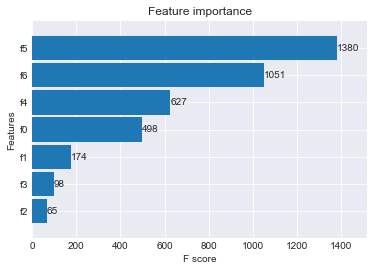

In [33]:
from xgboost import plot_importance, plot_tree
_ = plot_importance(xgb_reg, height=0.9)

In [34]:
X_train.head()

,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Net migration,days_since_first,previous_Recovered,recovery_rate
Country,,,,,,,
San Marino,"29,251",61,"4,795","1,098",11,0,0
South Korea,"48,846,823","98,480","4,960",0,42,30,0
Switzerland,"7,523,934","41,290","1,822",405,13,3,0
Australia,"20,264,082","7,686,850",26,398,11,2,0
Oman,"3,102,229","212,460",146,28,20,9,0


#### Testing the model

In [35]:
from sklearn.metrics import explained_variance_score
predictions = xgb_reg.predict(X_test.to_numpy())

In [36]:
pred_df = pd.DataFrame({'Actual':y_test.values, 'Pred':predictions}) 
pred_df

,Actual,Pred
0,3,3
1,0,0
2,1,1
3,1,1
4,0,-0
...,...,...
567,0,0
568,77,78
569,0,0
570,1,1


#### Evaluation results

In [37]:
print("MAE train: ", metrics.mean_absolute_error(y_train.to_numpy(), xgb_reg.predict(X_train.to_numpy()))) 
print("MSE train: ",metrics.mean_squared_error(y_train.to_numpy(), xgb_reg.predict(X_train.to_numpy())))
print("RMSE train: ",np.sqrt(metrics.mean_squared_error(y_train.to_numpy(), xgb_reg.predict(X_train.to_numpy()))))
print("r2: ",np.sqrt(metrics.r2_score(y_train.to_numpy(), xgb_reg.predict(X_train.to_numpy()))))

print("MAE test: ", metrics.mean_absolute_error(y_test.to_numpy(), xgb_reg.predict(X_test.to_numpy()))) 
print("MSE test: ",metrics.mean_squared_error(y_test.to_numpy(), xgb_reg.predict(X_test.to_numpy())))
print("RMSE test: ",np.sqrt(metrics.mean_squared_error(y_test.to_numpy(), xgb_reg.predict(X_test.to_numpy()))))
print("r2: ",np.sqrt(metrics.r2_score(y_test.to_numpy(), xgb_reg.predict(X_test.to_numpy()))))

MAE train:  0.45010543083910765
MSE train:  22.164519079685807
RMSE train:  4.7079208871523965
r2:  0.9999221423447218
MAE test:  3.061159143341588
MSE test:  582.319013113285
RMSE test:  24.13128701734089
r2:  0.9966530385494227


## XGBoost Regression -  For different countries

### Using Kaggle dataset to cross check the results of future prediction 

In [38]:
covid_df_kaggle= pd.read_csv("covid_19_data_Kaggle.csv")

In [39]:
covid_df_kaggle["ObservationDate"]=pd.to_datetime(covid_df_kaggle["ObservationDate"])

In [40]:
covid_df_kaggle.shape

(13850, 8)

### XGBoost Regression - Italy

In [41]:
covid_df_kaggle_Italy = covid_df_kaggle[covid_df_kaggle["Country/Region"] == "Italy"].groupby("ObservationDate").agg(
                {
                     'Confirmed':sum,    # Sum duration per group
                     'Recovered':sum,    # Sum duration per group
                     'Deaths':sum    # Sum duration per group
                }).sort_values(["ObservationDate"]).reset_index()

In [42]:
filter_condn = (covid_df_kaggle_Italy['ObservationDate'] > '2020-03-21') & (covid_df_kaggle_Italy['ObservationDate'] <= '2020-03-26')
covid_df_kaggle_Italy = covid_df_kaggle_Italy[filter_condn].reset_index()
covid_df_kaggle_Italy

X_Italy_df = X[X.index == "Italy"].copy()
X_Italy_test = X_Italy_df.head().copy()
X_Italy_test=X_Italy_test.reset_index(drop=True)
X_Italy_test['days_since_first'] = X_Italy_test['previous_Recovered'] = X_Italy_test['recovery_rate'] = 0
X_Italy_test.loc[0,'days_since_first'] =  X_Italy_df["days_since_first"].iloc[-1]+1
X_Italy_test.loc[0,'recovery_rate']=X_Italy_df["recovery_rate"].iloc[-1]+1
X_Italy_test.loc[0,'previous_Recovered'] = y[y.index == "Italy"].max()

for i in range(0,5):
    X_Italy_test.loc[i,'days_since_first'] = X_Italy_test.loc[0,'days_since_first'] + i

X_Italy_test

predictions=[]

for i in range(0,5):
    pred=int(xgb_reg.predict(X_Italy_test.iloc[i]))
    X_Italy_test.loc[i+1,'previous_Recovered']=pred
    predictions.append(pred)

pred = pd.DataFrame(predictions)

#### Prediction results
X_Italy_test['predicted_infections']=pred.iloc[:, 0] 
X_Italy_test=X_Italy_test[{'predicted_infections'}]
X_Italy_test["Actual infections"] = covid_df_kaggle_Italy["Recovered"]
X_Italy_test["Date"] = covid_df_kaggle_Italy["ObservationDate"]
X_Italy_test = X_Italy_test.iloc[0:5]
X_Italy_test 

,predicted_infections,Actual infections,Date
0,"7,401","7,024",2020-03-22
1,"6,206","7,432",2020-03-23
2,"5,831","8,326",2020-03-24
3,"5,633","9,362",2020-03-25
4,"5,621","10,361",2020-03-26


### XGBoost Regression - France

In [43]:
covid_df_kaggle_France = covid_df_kaggle[covid_df_kaggle["Country/Region"] == "France"].groupby("ObservationDate").agg(
                {
                     'Confirmed':sum,    # Sum duration per group
                     'Recovered':sum,    # Sum duration per group
                     'Deaths':sum    # Sum duration per group
                }).sort_values(["ObservationDate"]).reset_index()

In [44]:
filter_condn = (covid_df_kaggle_France['ObservationDate'] > '2020-03-21') & (covid_df_kaggle_France['ObservationDate'] <= '2020-03-26')
covid_df_kaggle_France = covid_df_kaggle_France[filter_condn].reset_index()
covid_df_kaggle_France

X_France_df = X[X.index == "France"].copy()
X_France_test = X_France_df.head().copy()
X_France_test=X_France_test.reset_index(drop=True)
X_France_test['days_since_first'] = X_France_test['previous_Recovered'] = X_France_test['recovery_rate'] = 0
X_France_test.loc[0,'days_since_first'] =  X_France_df["days_since_first"].iloc[-1]+1
X_France_test.loc[0,'recovery_rate']=X_France_df["recovery_rate"].iloc[-1]+1
X_France_test.loc[0,'previous_Recovered'] = y[y.index == "France"].max()

for i in range(0,5):
    X_France_test.loc[i,'days_since_first'] = X_France_test.loc[0,'days_since_first'] + i

X_France_test

predictions=[]

for i in range(0,5):
    pred=int(xgb_reg.predict(X_France_test.iloc[i]))
    X_France_test.loc[i+1,'previous_Recovered']=pred    
    predictions.append(pred)

pred = pd.DataFrame(predictions)

#### Prediction results
X_France_test['predicted_infections']=pred.iloc[:, 0] 
X_France_test=X_France_test[{'predicted_infections'}]
X_France_test["Actual infections"] = covid_df_kaggle_France["Recovered"]
X_France_test["Date"] = covid_df_kaggle_France["ObservationDate"]
X_France_test = X_France_test.iloc[0:5]
X_France_test 

,predicted_infections,Actual infections,Date
0,"3,213","2,201",2020-03-22
1,"3,673","2,207",2020-03-23
2,"3,673","3,288",2020-03-24
3,"3,673","3,907",2020-03-25
4,"3,673","4,955",2020-03-26


### XGBoost Regression - Spain

In [45]:
covid_df_kaggle_Spain = covid_df_kaggle[covid_df_kaggle["Country/Region"] == "Spain"].groupby("ObservationDate").agg(
                {
                     'Confirmed':sum,    # Sum duration per group
                     'Recovered':sum,    # Sum duration per group
                     'Deaths':sum    # Sum duration per group
                }).sort_values(["ObservationDate"]).reset_index()

In [46]:
filter_condn = (covid_df_kaggle_Spain['ObservationDate'] > '2020-03-21') & (covid_df_kaggle_Spain['ObservationDate'] <= '2020-03-26')
covid_df_kaggle_Spain = covid_df_kaggle_Spain[filter_condn].reset_index()
covid_df_kaggle_Spain

X_Spain_df = X[X.index == "Spain"].copy()
X_Spain_test = X_Spain_df.head().copy()
X_Spain_test=X_Spain_test.reset_index(drop=True)
X_Spain_test['days_since_first'] = X_Spain_test['previous_Recovered'] = X_Spain_test['recovery_rate'] = 0
X_Spain_test.loc[0,'days_since_first'] =  X_Spain_df["days_since_first"].iloc[-1]+1
X_Spain_test.loc[0,'recovery_rate']=X_Spain_df["recovery_rate"].iloc[-1]+1
X_Spain_test.loc[0,'previous_Recovered'] = y[y.index == "Spain"].max()

for i in range(0,5):
    X_Spain_test.loc[i,'days_since_first'] = X_Spain_test.loc[0,'days_since_first'] + i

X_Spain_test

predictions=[]

for i in range(0,5):
    pred=int(xgb_reg.predict(X_Spain_test.iloc[i]))
    X_Spain_test.loc[i+1,'previous_Recovered']=pred    
    predictions.append(pred)

pred = pd.DataFrame(predictions)

#### Prediction results
X_Spain_test['predicted_infections']=pred.iloc[:, 0] 
X_Spain_test=X_Spain_test[{'predicted_infections'}]
X_Spain_test["Actual infections"] = covid_df_kaggle_Spain["Recovered"]
X_Spain_test["Date"] = covid_df_kaggle_Spain["ObservationDate"]
X_Spain_test = X_Spain_test.iloc[0:5]
X_Spain_test 

,predicted_infections,Actual infections,Date
0,"3,557","2,125",2020-03-22
1,"3,604","3,355",2020-03-23
2,"3,604","3,794",2020-03-24
3,"3,604","5,367",2020-03-25
4,"3,604","7,015",2020-03-26


### XGBoost Regression - Germany

In [47]:
covid_df_kaggle_Germany = covid_df_kaggle[covid_df_kaggle["Country/Region"] == "Germany"].groupby("ObservationDate").agg(
                {
                     'Confirmed':sum,    # Sum duration per group
                     'Recovered':sum,    # Sum duration per group
                     'Deaths':sum    # Sum duration per group
                }).sort_values(["ObservationDate"]).reset_index()

In [48]:
filter_condn = (covid_df_kaggle_Germany['ObservationDate'] > '2020-03-21') & (covid_df_kaggle_Germany['ObservationDate'] <= '2020-03-26')
covid_df_kaggle_Germany = covid_df_kaggle_Germany[filter_condn].reset_index()
covid_df_kaggle_Germany

X_Germany_df = X[X.index == "Germany"].copy()
X_Germany_test = X_Germany_df.head().copy()
X_Germany_test=X_Germany_test.reset_index(drop=True)
X_Germany_test['days_since_first'] = X_Germany_test['previous_Recovered'] = X_Germany_test['recovery_rate'] = 0
X_Germany_test.loc[0,'days_since_first'] =  X_Germany_df["days_since_first"].iloc[-1]+1
X_Germany_test.loc[0,'recovery_rate']=X_Germany_df["recovery_rate"].iloc[-1]+1
X_Germany_test.loc[0,'previous_Recovered'] = y[y.index == "Germany"].max()

for i in range(0,5):
    X_Germany_test.loc[i,'days_since_first'] = X_Germany_test.loc[0,'days_since_first'] + i

X_Germany_test

predictions=[]

for i in range(0,5):
    pred=int(xgb_reg.predict(X_Germany_test.iloc[i]))
    X_Germany_test.loc[i+1,'previous_Recovered']=pred    
    predictions.append(pred)

pred = pd.DataFrame(predictions)

#### Prediction results
X_Germany_test['predicted_infections']=pred.iloc[:, 0] 
X_Germany_test=X_Germany_test[{'predicted_infections'}]
X_Germany_test["Actual infections"] = covid_df_kaggle_Germany["Recovered"]
X_Germany_test["Date"] = covid_df_kaggle_Germany["ObservationDate"]
X_Germany_test = X_Germany_test.iloc[0:5]
X_Germany_test 

,predicted_infections,Actual infections,Date
0,496,266,2020-03-22
1,508,453,2020-03-23
2,506,"3,243",2020-03-24
3,506,"3,547",2020-03-25
4,492,"5,673",2020-03-26


### XGBoost Regression - Switzerland

In [49]:
covid_df_kaggle_Switzerland = covid_df_kaggle[covid_df_kaggle["Country/Region"] == "Switzerland"].groupby("ObservationDate").agg(
                {
                     'Confirmed':sum,    # Sum duration per group
                     'Recovered':sum,    # Sum duration per group
                     'Deaths':sum    # Sum duration per group
                }).sort_values(["ObservationDate"]).reset_index()

In [50]:
filter_condn = (covid_df_kaggle_Switzerland['ObservationDate'] > '2020-03-21') & (covid_df_kaggle_Switzerland['ObservationDate'] <= '2020-03-26')
covid_df_kaggle_Switzerland = covid_df_kaggle_Switzerland[filter_condn].reset_index()
covid_df_kaggle_Switzerland

X_Switzerland_df = X[X.index == "Switzerland"].copy()
X_Switzerland_test = X_Switzerland_df.head().copy()
X_Switzerland_test=X_Switzerland_test.reset_index(drop=True)
X_Switzerland_test['days_since_first'] = X_Switzerland_test['previous_Recovered'] = X_Switzerland_test['recovery_rate'] = 0
X_Switzerland_test.loc[0,'days_since_first'] =  X_Switzerland_df["days_since_first"].iloc[-1]+1
X_Switzerland_test.loc[0,'recovery_rate']=X_Switzerland_df["recovery_rate"].iloc[-1]+1
X_Switzerland_test.loc[0,'previous_Recovered'] = y[y.index == "Switzerland"].max()

for i in range(0,5):
    X_Switzerland_test.loc[i,'days_since_first'] = X_Switzerland_test.loc[0,'days_since_first'] + i

X_Switzerland_test

predictions=[]

for i in range(0,5):
    pred=int(xgb_reg.predict(X_Switzerland_test.iloc[i]))
    X_Switzerland_test.loc[i+1,'previous_Recovered']=pred    
    predictions.append(pred)

pred = pd.DataFrame(predictions)

#### Prediction results
X_Switzerland_test['predicted_infections']=pred.iloc[:, 0] 
X_Switzerland_test=X_Switzerland_test[{'predicted_infections'}]
X_Switzerland_test["Actual infections"] = covid_df_kaggle_Switzerland["Recovered"]
X_Switzerland_test["Date"] = covid_df_kaggle_Switzerland["ObservationDate"]
X_Switzerland_test = X_Switzerland_test.iloc[0:5]
X_Switzerland_test 

,predicted_infections,Actual infections,Date
0,246,131,2020-03-22
1,254,131,2020-03-23
2,256,131,2020-03-24
3,261,131,2020-03-25
4,261,131,2020-03-26
